<a href="https://colab.research.google.com/github/ritwikthakar/Neural-Network-Deep-Learning-Models/blob/main/AlphabetSoupCharity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deliverable 1: Preprocessing the Data for a Neural Network

In [3]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
import pandas as pd
url = 'https://raw.githubusercontent.com/ritwikthakar/Neural-Network-Deep-Learning-Models/main/charity_data.csv' 
application_df = pd.read_csv(url)
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df=application_df.drop(columns=["EIN", "NAME"])
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [5]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [6]:
# Look at APPLICATION_TYPE value counts for binning
app_col= application_df["APPLICATION_TYPE"].value_counts()
app_col

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T14        3
T25        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

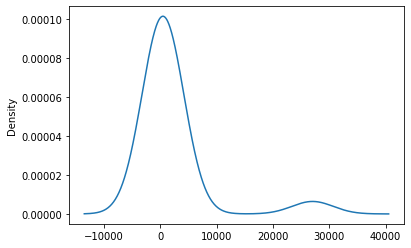

In [7]:
# Visualize the value counts of APPLICATION_TYPE
application_df["APPLICATION_TYPE"].value_counts().plot.density()

In [8]:
# Determine which values to replace if counts are less than ...?
replace_application= app_col[app_col < 500].index.tolist()

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [9]:
# Generate our categorical variable lists
application_ctg= application_df.dtypes[application_df.dtypes =="object"].index.tolist()
application_df[application_ctg].nunique()

APPLICATION_TYPE           9
AFFILIATION                6
CLASSIFICATION            71
USE_CASE                   5
ORGANIZATION               4
INCOME_AMT                 9
SPECIAL_CONSIDERATIONS     2
dtype: int64

In [12]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df=pd.DataFrame(enc.fit_transform(application_df[application_ctg]))
encode_df.head()

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_ctg)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C0,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C1230,CLASSIFICATION_C1234,CLASSIFICATION_C1235,CLASSIFICATION_C1236,CLASSIFICATION_C1237,CLASSIFICATION_C1238,CLASSIFICATION_C1240,CLASSIFICATION_C1245,CLASSIFICATION_C1246,CLASSIFICATION_C1248,CLASSIFICATION_C1250,CLASSIFICATION_C1256,CLASSIFICATION_C1257,CLASSIFICATION_C1260,CLASSIFICATION_C1267,CLASSIFICATION_C1270,CLASSIFICATION_C1278,CLASSIFICATION_C1280,CLASSIFICATION_C1283,CLASSIFICATION_C1300,CLASSIFICATION_C1370,CLASSIFICATION_C1400,...,CLASSIFICATION_C3000,CLASSIFICATION_C3200,CLASSIFICATION_C3700,CLASSIFICATION_C4000,CLASSIFICATION_C4100,CLASSIFICATION_C4120,CLASSIFICATION_C4200,CLASSIFICATION_C4500,CLASSIFICATION_C5000,CLASSIFICATION_C5200,CLASSIFICATION_C6000,CLASSIFICATION_C6100,CLASSIFICATION_C7000,CLASSIFICATION_C7100,CLASSIFICATION_C7120,CLASSIFICATION_C7200,CLASSIFICATION_C7210,CLASSIFICATION_C8000,CLASSIFICATION_C8200,CLASSIFICATION_C8210,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
# Merge one-hot encoded features and drop the originals
prep_application_df= application_df.merge(encode_df, left_index=True, right_index=True).drop(columns= application_ctg)
prep_application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C0,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C1230,CLASSIFICATION_C1234,CLASSIFICATION_C1235,CLASSIFICATION_C1236,CLASSIFICATION_C1237,CLASSIFICATION_C1238,CLASSIFICATION_C1240,CLASSIFICATION_C1245,CLASSIFICATION_C1246,CLASSIFICATION_C1248,CLASSIFICATION_C1250,CLASSIFICATION_C1256,CLASSIFICATION_C1257,CLASSIFICATION_C1260,CLASSIFICATION_C1267,CLASSIFICATION_C1270,CLASSIFICATION_C1278,CLASSIFICATION_C1280,CLASSIFICATION_C1283,...,CLASSIFICATION_C3000,CLASSIFICATION_C3200,CLASSIFICATION_C3700,CLASSIFICATION_C4000,CLASSIFICATION_C4100,CLASSIFICATION_C4120,CLASSIFICATION_C4200,CLASSIFICATION_C4500,CLASSIFICATION_C5000,CLASSIFICATION_C5200,CLASSIFICATION_C6000,CLASSIFICATION_C6100,CLASSIFICATION_C7000,CLASSIFICATION_C7100,CLASSIFICATION_C7120,CLASSIFICATION_C7200,CLASSIFICATION_C7210,CLASSIFICATION_C8000,CLASSIFICATION_C8200,CLASSIFICATION_C8210,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
# Split our preprocessed data into our features and target arrays
y= prep_application_df["IS_SUCCESSFUL"].values
X= prep_application_df.drop(columns= ["IS_SUCCESSFUL"]).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test= train_test_split(X,y,random_state=30)

In [16]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [17]:
print(len(prep_application_df.columns))

109


### Deliverable 2: Compile, Train and Evaluate the Model

In [18]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features= len(X_train[0])
hidden_layers1= 30
hidden_layers2= 25


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layers1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layers2, input_dim=number_input_features, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                3270      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                775       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 4,071
Trainable params: 4,071
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compile the model
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

nn.compile(loss="binary_crossentropy", optimizer="adam", metrics= ["accuracy"])

In [22]:
# Create a callback which saves the weights for every 5 epochs
cp_callback= ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True, save_freq=5)

In [23]:
# Train the model
fit_model= nn.fit(X_train_scaled, y_train, epochs=100, verbose=1, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 3s 3ms/step - loss: 0.5789 - accuracy: 0.7198
Epoch 2/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5521 - accuracy: 0.7317
Epoch 3/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5476 - accuracy: 0.7343
Epoch 4/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5453 - accuracy: 0.7340
Epoch 5/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5444 - accuracy: 0.7356
Epoch 6/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5433 - accuracy: 0.7350
Epoch 7/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5427 - accuracy: 0.7360
Epoch 8/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5419 - accuracy: 0.7364
Epoch 9/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5411 - accuracy: 0.7379
Epoch 10/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5407 - accura

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5695 - accuracy: 0.7220
Loss: 0.5695399045944214, Accuracy: 0.721982479095459


In [27]:
# Export our model to HDF5 file
nn.save("C:/Users/ritwi/Documents/Assignment 19/AlphabetSoupCharity.h5")